# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [5]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

C:\Users\Richie\anaconda3\lib\site-packages\IPython\core\display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [259]:
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
df['Data_Value'] = df['Data_Value']/10

df['year'] = df['Date'].apply(lambda x:x.split('-')[0])
df['md'] = df['Date'].apply(lambda x:x.split('-',1)[1])
df['m'] = df['Date'].apply(lambda x:x.split('-')[1])
#dropping leap years
df = df[df['md']!='02-29']
#separating by max and min
Tmax = df[df['Element']=='TMAX']
Tmin = df[df['Element']=='TMIN']
#separating by year
TmaxBase = Tmax[Tmax['year']!='2015']
Tmax15 = Tmax[Tmax['year']=='2015']
TminBase = Tmin[Tmin['year']!='2015']
Tmin15 = Tmin[Tmin['year']=='2015']

# clean to basic columns
TmaxBase = TmaxBase[['md','Data_Value']]
TminBase = TminBase[['md','Data_Value']]
Tmax15 = Tmax15[['md','Data_Value']]
Tmin15 = Tmin15[['md','Data_Value']]

#get maxs and mins by groupby
TmaxBase = TmaxBase.groupby('md').max()
TminBase = TminBase.groupby('md').min()
Tmax15 = Tmax15.groupby('md').max()
Tmin15 = Tmin15.groupby('md').min()

#identify days in which 2015 max overpass 2005-2014 max
MaxBroken = Tmax15.merge(TmaxBase,left_index=True,right_index=True)
MaxBroken = MaxBroken[MaxBroken['Data_Value_x']>MaxBroken['Data_Value_y']]
MaxBroken = MaxBroken.reset_index()
MaxBroken['time'] = MaxBroken['md'].apply(lambda x:datetime.datetime(2015, int(x.split('-')[0]), int(x.split('-')[1]), 0, 0, 1))
MaxBroken.head()

#identify days in which 2015 min overpass 2005-2014 min
MinBroken = Tmin15.merge(TminBase,left_index=True,right_index=True)
MinBroken = MinBroken[MinBroken['Data_Value_x']<MinBroken['Data_Value_y']]
MinBroken = MinBroken.reset_index()
MinBroken['time'] = MinBroken['md'].apply(lambda x:datetime.datetime(2015, int(x.split('-')[0]), int(x.split('-')[1]), 0, 0, 1))
MinBroken.shape


(32, 4)

<IPython.core.display.Javascript object>


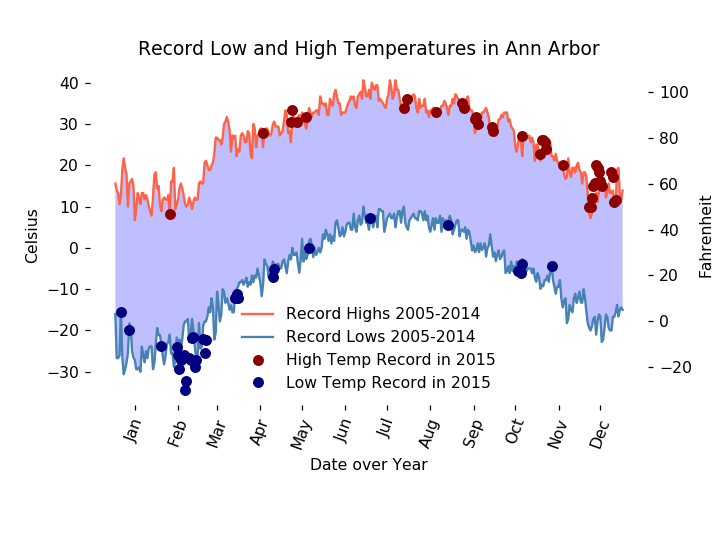

No handles with labels found to put in legend.


In [297]:
%matplotlib notebook

import numpy as np
import datetime

x = np.array([1,2,3,4,5,6,7,8])


plt.figure()

base = datetime.datetime(2015, 1, 1, 0, 0, 1)
time = [base + datetime.timedelta(days=x) for x in range(365)]

plt.plot(time, TmaxBase.Data_Value, '-', color='tomato')
plt.plot(time, TminBase.Data_Value,'-', color='steelblue')

#formatting bottom ticks
locator = mdates.DayLocator(bymonthday=[15])
formatter = mdates.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().tick_params(axis='x', rotation=70)

#cleaning ticks 
plt.gca().set_xticks(plt.gca().get_xticks()[1:-1])

# fill the area between the max and min
plt.gca().fill_between(time, 
                       TmaxBase.Data_Value, TminBase.Data_Value, 
                       facecolor='blue', 
                       alpha=0.25)


# Overlay a scatter of the 2015 data for any points (highs and lows) 
# for which the ten year record (2005-2014) record high or record low was broken in 2015.
plt.plot(MaxBroken.time,MaxBroken.Data_Value_x,'o',color='darkred')
plt.plot(MinBroken.time,MinBroken.Data_Value_x,'o',color='navy')


def CtoF(x):
    return (x * 1.8) + 32

def FtoC(x):
    return (x - 32) / 1.8

secax = plt.gca().secondary_yaxis('right', functions=(CtoF, FtoC))
secax.set_ylabel('Fahrenheit')
secax.set_frame_on(False)

plt.xlabel('Date over Year')
plt.ylabel('Celsius')
plt.title('Record Low and High Temperatures in Ann Arbor')
# add a legend with legend entries (because we didn't have labels when we plotted the data series)
plt.legend()
# add the legend to loc=4 (the lower right hand corner), also gets rid of the frame and adds a title
plt.legend(['Record Highs 2005-2014', 'Record Lows 2005-2014','High Temp Record in 2015','Low Temp Record in 2015'],
           loc=8, frameon=False)

# adjust the subplot so the text doesn't run off the image
plt.subplots_adjust(bottom=0.25)
plt.box(False)
        
plt.show()

